In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [10]:
image_size = (140, 140)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 3270 files belonging to 2 classes.
Using 2616 files for training.
Found 3270 files belonging to 2 classes.
Using 654 files for validation.


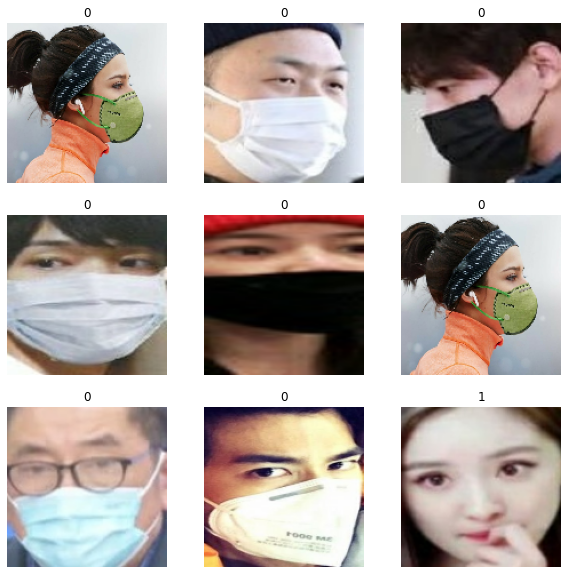

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

plt.savefig('data_example.jpg', dpi=500)


In [12]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

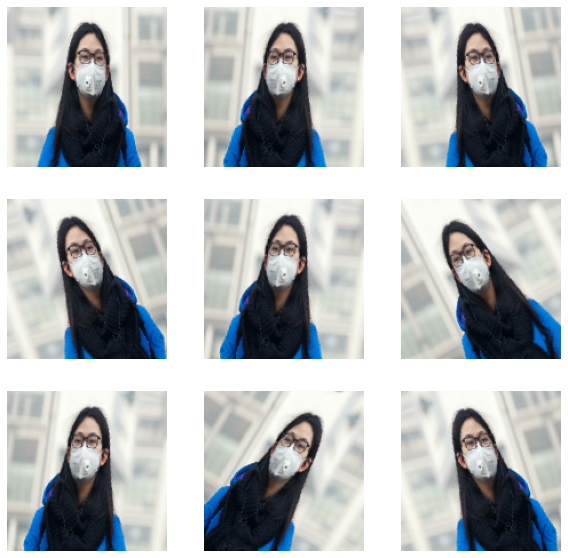

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

plt.savefig('augmentation_example.jpg', dpi=500)


In [14]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


In [15]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
model.summary()
keras.utils.plot_model(model, show_shapes=True, to_file="model.jpg", dpi=200)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 140, 140, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 140, 140, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 140, 140, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 70, 70, 32)   896         ['rescaling[0][0]']          

In [8]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/50
82/82 [==============================] - 24s 175ms/step - loss: 0.3680 - accuracy: 0.8559 - val_loss: 0.6885 - val_accuracy: 0.5275


C:\Users\olsen\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 2/50
82/82 [==============================] - 12s 143ms/step - loss: 0.2305 - accuracy: 0.9117 - val_loss: 0.6801 - val_accuracy: 0.5275
Epoch 3/50
82/82 [==============================] - 12s 143ms/step - loss: 0.2217 - accuracy: 0.9170 - val_loss: 0.6629 - val_accuracy: 0.6254
Epoch 4/50
82/82 [==============================] - 12s 147ms/step - loss: 0.2057 - accuracy: 0.9235 - val_loss: 0.6892 - val_accuracy: 0.5275
Epoch 5/50
82/82 [==============================] - 12s 149ms/step - loss: 0.1514 - accuracy: 0.9438 - val_loss: 0.4849 - val_accuracy: 0.8609
Epoch 6/50
82/82 [==============================] - 12s 146ms/step - loss: 0.1331 - accuracy: 0.9530 - val_loss: 0.1838 - val_accuracy: 0.9511
Epoch 7/50
82/82 [==============================] - 12s 145ms/step - loss: 0.1277 - accuracy: 0.9541 - val_loss: 0.1754 - val_accuracy: 0.9404
Epoch 8/50
82/82 [==============================] - 12s 144ms/step - loss: 0.1031 - accuracy: 0.9614 - val_loss: 0.1065 - val_accuracy: 0.9664

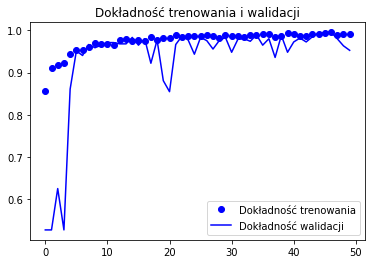

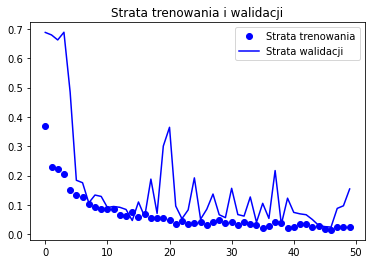

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Dokładność trenowania')
plt.plot(epochs, val_acc, 'b', label='Dokładność walidacji')
plt.title('Dokładność trenowania i walidacji')
plt.legend()

plt.savefig('dokladnosc_trenowania_i_walidacji.jpg', dpi=500)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()

plt.savefig('straty_trenowania_i_walidacji.jpg', dpi=500)
plt.show()

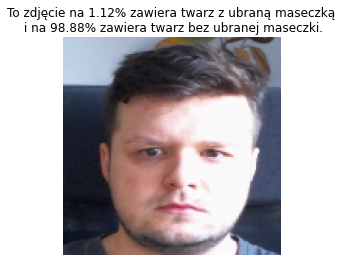

In [10]:
img = keras.preprocessing.image.load_img(
    "test_images/without_mask.png", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]

plt.imshow(img)
plt.title("To zdjęcie na %.2f%% zawiera twarz z ubraną maseczką\n i na %.2f%% zawiera twarz bez ubranej maseczki." % (100 * (1 - score), 100 * score))
plt.axis("off")

plt.savefig('prediction_without_mask.jpg', dpi=500)


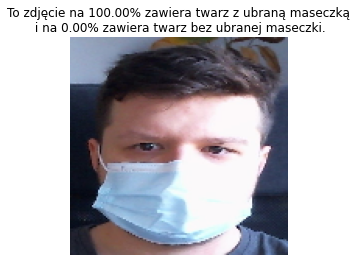

In [11]:
img = keras.preprocessing.image.load_img(
    "test_images/with_mask.png", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]

plt.imshow(img)
plt.title("To zdjęcie na %.2f%% zawiera twarz z ubraną maseczką\n i na %.2f%% zawiera twarz bez ubranej maseczki." % (100 * (1 - score), 100 * score))
plt.axis("off")

plt.savefig('prediction_with_mask.jpg', dpi=500)

In [12]:
model.save('saved_model.h5')

In [13]:
model = keras.models.load_model('saved_model.h5')

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset_test",
    image_size=image_size,
    batch_size=batch_size,
)

model.evaluate(test_ds)


Found 819 files belonging to 2 classes.
26/26 [==============================] - 2s 76ms/step - loss: 0.3820 - accuracy: 0.8852


[0.3820214569568634, 0.8852258920669556]

[[401  32]
 [ 20 366]]


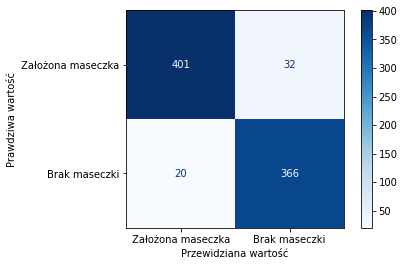

In [6]:
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

with_mask = [f for f in listdir('dataset_test/with_mask') if isfile(join('dataset_test/with_mask', f))]
without_mask = [f for f in listdir('dataset_test/without_mask') if isfile(join('dataset_test/without_mask', f))]

y_true = []
y_pred = []

model = models.load_model('saved_model_base.h5')

for photo in with_mask:

    frame = cv2.imread(join('dataset_test','with_mask',photo))

    img_array = keras.preprocessing.image.img_to_array(cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB),(140,140)))
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    y_true.append(0)

    y_pred.append(round(float(predictions[0])))

for photo in without_mask:

    frame = cv2.imread(join('dataset_test','without_mask',photo))

    img_array = keras.preprocessing.image.img_to_array(cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB),(140,140)))
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    y_true.append(1)

    y_pred.append(round(float(predictions[0])))

cm = confusion_matrix(y_true, y_pred)

print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Założona maseczka', 'Brak maseczki'])

disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Przewidziana wartość')
plt.ylabel('Prawdziwa wartość')
plt.savefig('confusion_matrix_500dpi.jpg', dpi=400, bbox_inches='tight')
plt.show()
